
# 1/Import Libraries

In [1]:
# for missing days in time series dates
library(padr)

# for tsclean outlier treatment
library(forecast)

# for data manipulation
library(dplyr)

# for fitting forecasting model
library(prophet)

# to diagnose forecast
library(Metrics)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘Metrics’


The following object is masked from ‘package:rlang’:

    ll


The following object is masked from ‘package:forecast’:

    accuracy





# 2/ Import Data

In [2]:
train <- read.csv('../input/u-j-time-series-forecasting-case-study/train.csv')
test <- read.csv('../input/u-j-time-series-forecasting-case-study/test.csv')
sample <- read.csv('../input/u-j-time-series-forecasting-case-study/sample_submission.csv')
hl <- read.csv('../input/u-j-time-series-forecasting-case-study/holidays.csv')

# 3/ Check Data

In [3]:
# Check Head and Tail
head(train)
tail(train)
head(test)
tail(test)
head(hl)
tail(hl)

,date,transactions
,<chr>,<int>
1,01-01-2013,770
2,02-01-2013,93215
3,03-01-2013,78504
4,04-01-2013,78494
5,05-01-2013,93573
6,06-01-2013,90464


,date,transactions
,<chr>,<int>
1450,26-12-2016,105524
1451,27-12-2016,95643
1452,28-12-2016,103717
1453,29-12-2016,102665
1454,30-12-2016,127771
1455,31-12-2016,135568


,date,id
,<chr>,<int>
1,01-01-2017,0
2,02-01-2017,1
3,03-01-2017,2
4,04-01-2017,3
5,05-01-2017,4
6,06-01-2017,5


,date,id
,<chr>,<int>
222,10-08-2017,221
223,11-08-2017,222
224,12-08-2017,223
225,13-08-2017,224
226,14-08-2017,225
227,15-08-2017,226


,Date,Holidays
,<chr>,<int>
1,02-03-2012,1
2,01-04-2012,1
3,12-04-2012,1
4,14-04-2012,1
5,21-04-2012,1
6,12-05-2012,1


,Date,Holidays
,<chr>,<int>
307,21-12-2017,1
308,22-12-2017,2
309,23-12-2017,1
310,24-12-2017,1
311,25-12-2017,1
312,26-12-2017,1


# 4/ Basic Data Sanity and Data Manipulation

In [4]:
# Convert date in proper format
head(train$date)
train$date<-as.Date(train$date, format="%d-%m-%Y")
head(train$date)

[1] "01-01-2013" "02-01-2013" "03-01-2013" "04-01-2013" "05-01-2013"
[6] "06-01-2013"

[1] "2013-01-01" "2013-01-02" "2013-01-03" "2013-01-04" "2013-01-05"
[6] "2013-01-06"

In [5]:
# Convert date in proper format for holidays list
head(hl$Date)
hl$Date<-as.Date(hl$Date, format="%d-%m-%Y")
head(hl$Date)

[1] "02-03-2012" "01-04-2012" "12-04-2012" "14-04-2012" "21-04-2012"
[6] "12-05-2012"

[1] "2012-03-02" "2012-04-01" "2012-04-12" "2012-04-14" "2012-04-21"
[6] "2012-05-12"

In [6]:
# Checking for NA
colSums(is.na(train))

date transactions 
           0            0

In [7]:
# Find missing days in date column and create records with transaction value = 0
train <- train %>% pad
train$transactions %>% is.na %>% sum
train <- train %>% pad %>% fill_by_value(transactions, value = 0)
subset(train,train$transactions=="0")
tail(train,n=10)

pad applied on the interval: day



[1] 6

pad applied on the interval: day



,date,transactions
,<date>,<dbl>
359,2013-12-25,0
724,2014-12-25,0
1089,2015-12-25,0
1096,2016-01-01,0
1098,2016-01-03,0
1455,2016-12-25,0


,date,transactions
,<date>,<dbl>
1452,2016-12-22,138892
1453,2016-12-23,156932
1454,2016-12-24,167542
1455,2016-12-25,0
1456,2016-12-26,105524
1457,2016-12-27,95643
1458,2016-12-28,103717
1459,2016-12-29,102665
1460,2016-12-30,127771


In [8]:
# Find average of 1 Jan for every year
Jan1_2013 <-subset(train,train$date=="2013-01-01")
Jan1_2014 <-subset(train,train$date=="2014-01-01")
Jan1_2015 <-subset(train,train$date=="2015-01-01")
round((Jan1_2013$transactions+Jan1_2014$transactions+Jan1_2015$transactions)/3,0)
# Update value for 2016-01-01 in train
train$transactions[train$date == '2016-01-01'] <- 1433
subset(train,train$date=="2016-01-01")

[1] 1433

,date,transactions
,<date>,<dbl>
1096,2016-01-01,1433


In [9]:
# Find average of 3 Jan for every year
Jan3_2013 <-subset(train,train$date=="2013-01-03")
Jan3_2014 <-subset(train,train$date=="2014-01-03")
Jan3_2015 <-subset(train,train$date=="2015-01-03")
round((Jan3_2013$transactions+Jan3_2014$transactions+Jan3_2015$transactions)/3,0)
# Update value for 2016-01-03 in MissingDaysDF
train$transactions[train$date == '2016-01-03'] <- 86427
subset(train,train$date=="2016-01-03")

[1] 86427

,date,transactions
,<date>,<dbl>
1098,2016-01-03,86427


In [10]:
# Create new variable 'Holidays' to identify days with holidays for all rows in train
colnames(hl) <- c('date','holiday')
train_hl <- left_join(train,hl,by='date')
colSums(is.na(train_hl))
train_hl$holiday[is.na(train_hl$holiday)] <- 0
colSums(is.na(train_hl))
colnames(train_hl) <- c('ds','y','holiday')

date transactions      holiday 
           0            0         1231

date transactions      holiday 
           0            0            0

In [11]:
hl1 <- data.frame(train_hl$ds,train_hl$holiday)
colnames(hl1) <- c('ds','holiday')
tail(hl1)

,ds,holiday
,<date>,<dbl>
1456,2016-12-26,1
1457,2016-12-27,0
1458,2016-12-28,0
1459,2016-12-29,0
1460,2016-12-30,0
1461,2016-12-31,1


In [12]:
# Cleaning time series data for normality of residuals
train_hl$y<-tsclean(train_hl$y, replace.missing = TRUE, iterate = 10, lambda = "auto")

Warning message in guerrero(x, lower, upper):
“Guerrero's method for selecting a Box-Cox parameter (lambda) is given for strictly positive data.”



# 5/ EDA - Plot Data

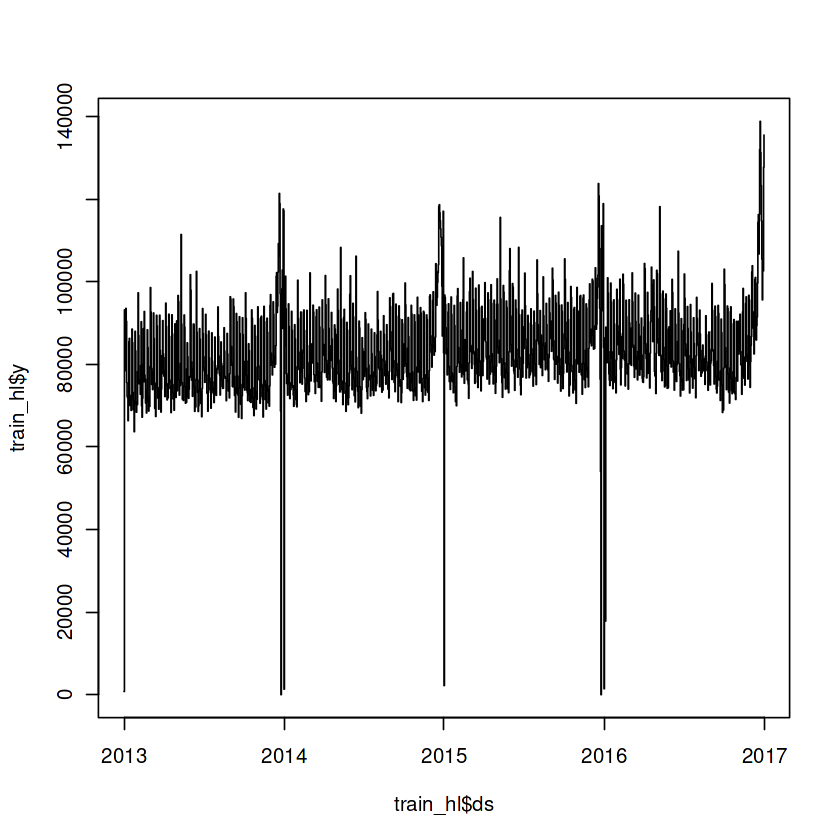

In [13]:
# Get scatter plot for date and transaction
plot(train_hl$ds,train_hl$y, type = "s")

# 6/ Build PROPHET forecasting Models

In [14]:
# Working for extra regressor in prophet
date_range1 <- seq(as.Date("2013/01/01"), by = "day", length.out = 1826)
date_range1_DF <- data.frame(date_range1,as.integer(0))
colnames(date_range1_DF) <- c('date','holiday')
hl_till_2017 <- left_join(date_range1_DF,hl,by='date')
hl2_till_2017 <- data.frame(hl_till_2017$date,hl_till_2017$holiday.y)
colnames(hl2_till_2017) <- c('ds','holiday')
colSums(is.na(hl2_till_2017))
hl2_till_2017$holiday[is.na(hl2_till_2017$holiday)] <- 0
colSums(is.na(hl2_till_2017))
head(hl2_till_2017)
tail(hl2_till_2017)

ds holiday 
      0    1549

ds holiday 
      0       0

,ds,holiday
,<date>,<dbl>
1,2013-01-01,1
2,2013-01-02,0
3,2013-01-03,0
4,2013-01-04,0
5,2013-01-05,1
6,2013-01-06,0


,ds,holiday
,<date>,<dbl>
1821,2017-12-26,1
1822,2017-12-27,0
1823,2017-12-28,0
1824,2017-12-29,0
1825,2017-12-30,0
1826,2017-12-31,0


In [15]:
# Creating PROPHET model
m = prophet(changepoint.prior.scale = 0.1,seasonality.prior.scale=1)
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
# adding external aggressors
m = add_regressor(m,'holiday',standardize = FALSE)
# fitting a prophet model
m = fit.prophet(m, df = train_hl)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.




# 7/ Forecast using PROPHET model

Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
ℹ Please use `select()` instead.
ℹ The deprecated feature was likely used in the dplyr package.
  Please report the issue at <https://github.com/tidyverse/dplyr/issues>.”


HTML widgets cannot be represented in plain text (need html)

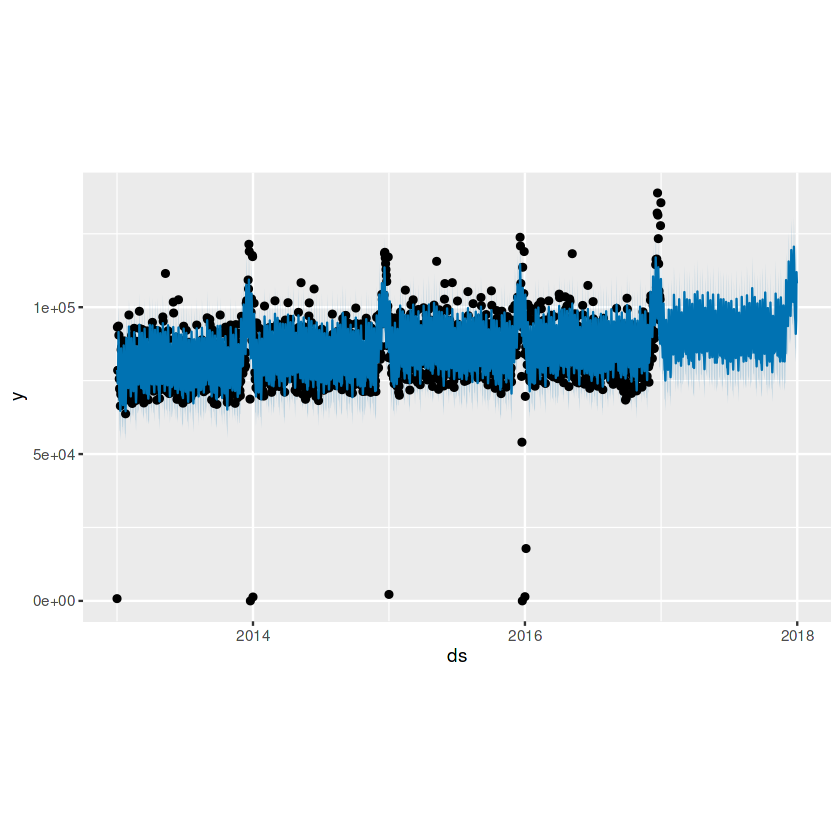

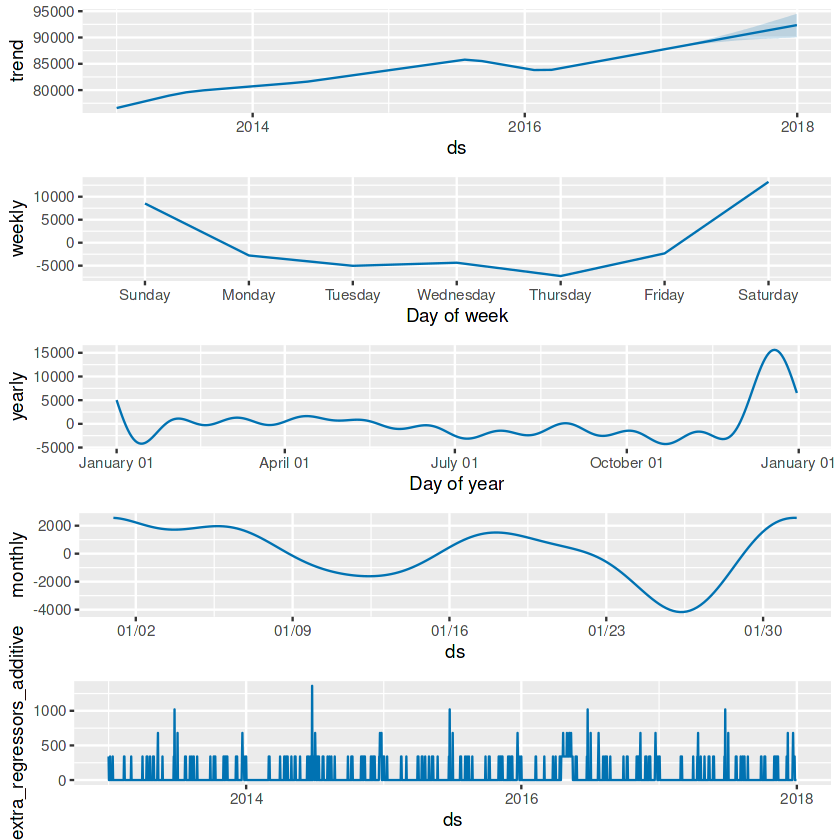

In [16]:
# Make future dataframe using PROPHET model
future <- make_future_dataframe(m, periods = 365,include_history = TRUE)
# Passing holiday dataframe for regression
future$holiday <- hl2_till_2017$holiday
# Forecast using PROPHET model
forecast <- predict(m, future)
plot(m, forecast)
# Creating interactive plots for the forecast
dyplot.prophet(m,forecast,uncertainty = TRUE) 
# Components of PORPHET forecast
prophet_plot_components(m, forecast)

In [17]:
# Forecasted values from PROPHET model
predicted <- data.frame(forecast$ds,forecast$yhat)

# 8/ Check Performance

Warning message in base::check_tzones(e1, e2):
“'tzone' attributes are inconsistent”
Warning message in base::check_tzones(e1, e2):
“'tzone' attributes are inconsistent”


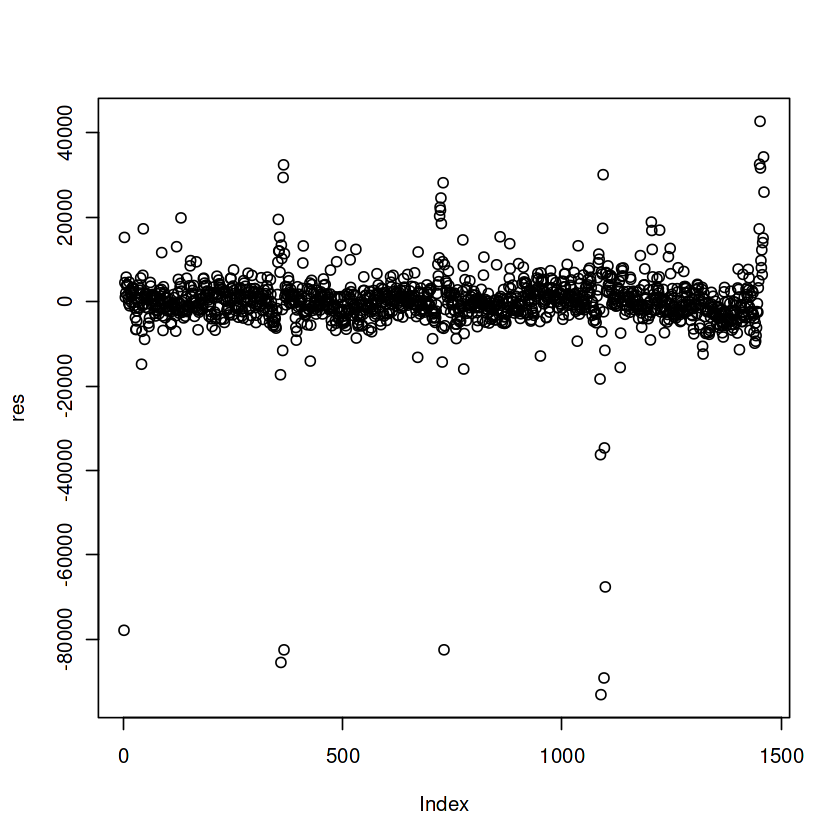

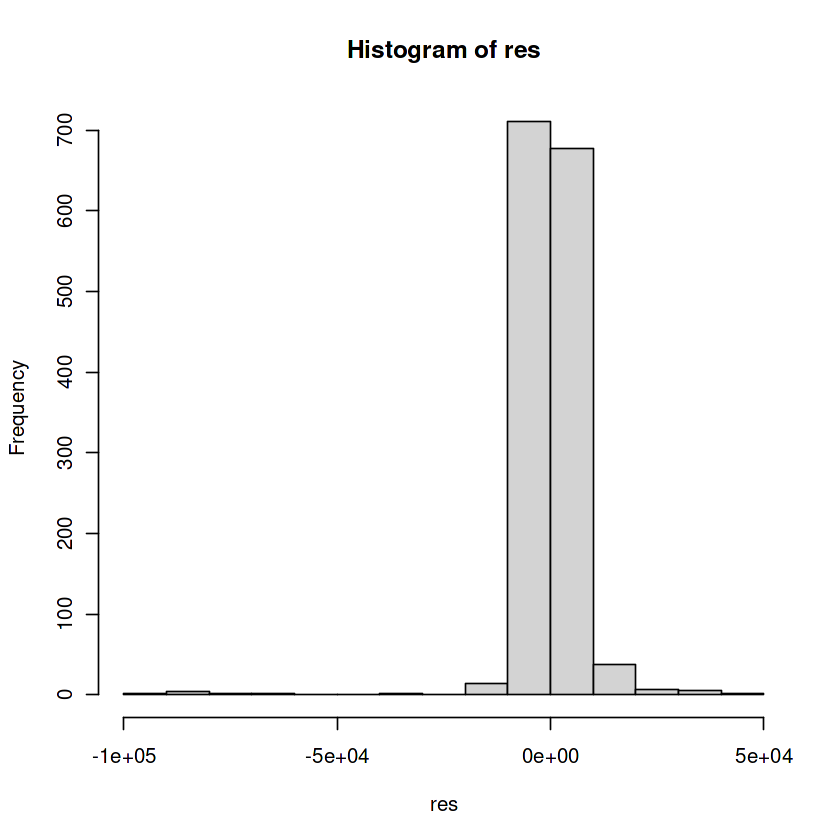

In [18]:
# Identify residuals on transformaed y
yhat_org <- predicted %>% filter(forecast.ds >= as.Date("2013-01-01") & forecast.ds < as.Date("2017-01-01"))
compare <- data.frame(train_hl$y,yhat_org$forecast.yhat)
colnames(compare) <- c("Actual Values", "forecasted Values")
res <- train_hl$y - yhat_org$forecast.yhat
# Plot residuals
plot(res)
# Plot residuals for Normality
hist(res)

In [19]:
# Normality test
Box.test(res, type = "Ljung-Box")


	Box-Ljung test

data:  res
X-squared = 86.358, df = 1, p-value < 2.2e-16


In [20]:
# Calculate diagnostic parameters on transformaed y
# MAPE
percentage_error <- abs((train_hl$y - yhat_org$forecast.yhat)/(train_hl$y))
mean(percentage_error)
# INF

[1] Inf

In [21]:
#sMAPE
library(Metrics)
smape(train_hl$y,yhat_org$forecast.yhat)

# Custom function to calculate SMAPE
computeSmape <- function(actual, forecast) {
  return (1 / length(actual) * sum(2 * abs(forecast - actual) / (abs(actual)  + abs(forecast))))
}
# Determine SMAPE
computeSmape(train_hl$y,yhat_org$forecast.yhat)

[1] 0.04686604

[1] 0.04686604

In [22]:
# RMSE
sq_error<- (train_hl$y - yhat_org$forecast.yhat)^2
MSE <- mean(sq_error)
RMSE <- sqrt(MSE)
RMSE

[1] 7740.012

In [23]:
# RMSLE
rmsle(train_hl$y,yhat_org$forecast.yhat)
RMSLE = sqrt(mean((log(yhat_org$forecast.yhat + 1) - log(train_hl$y + 1))^2))  
RMSLE

[1] 0.4796925

[1] 0.4796925


# 9/ Output / Submission

In [24]:
# Submission
predict_2017 <- predicted %>% filter(forecast.ds >= as.Date("2017-01-01") & forecast.ds < as.Date("2017-08-16"))
colnames(predict_2017) <- c("date", "forecast.yhat")
predict_2017$forecast.yhat <- round(predict_2017$forecast.yhat,0)
test$date<-as.Date(test$date, format="%d-%m-%Y")
predict_2017_id <- left_join(test,predict_2017, by='date')

# Create submission file
submission <- data.frame(predict_2017_id$id,predict_2017_id$forecast.yhat)
colnames(submission) <- c("id", "transactions")
submission$transactions[submission$id == '0'] <- 1433
head(submission)
tail(submission)
write.csv(submission,"submission.csv", row.names = FALSE, na = '0')


Warning message in base::check_tzones(e1, e2):
“'tzone' attributes are inconsistent”
Warning message in base::check_tzones(e1, e2):
“'tzone' attributes are inconsistent”


,id,transactions
,<int>,<dbl>
1,0,1433
2,1,91277
3,2,87136
4,3,86635
5,4,82890
6,5,86919


,id,transactions
,<int>,<dbl>
222,221,81486
223,222,85606
224,223,100294
225,224,95345
226,225,84067
227,226,82498
